# Variational Autoencoder in TensorFlow

The main motivation for this post was that I wanted to get more experience with both [Variational Autoencoders](http://arxiv.org/abs/1312.6114) (VAEs) and with [Tensorflow](http://www.tensorflow.org/). Thus, implementing the former in the latter sounded like a good idea for learning about both at the same time. This post summarizes the result.

Note: The post was updated on December 7th 2015:
  * a bug in the computation of the latent_loss was fixed (removed an erroneous factor 2). Thanks Colin Fang for pointing this out.
  * Using a Bernoulli distribution rather than a Gaussian distribution in the generator network

Let us first do the necessary imports, load the data (MNIST), and define some helper functions.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

In [2]:
# Load MNIST data in a format suited for tensorflow.
# The script input_data is available under this URL:
# https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/g3doc/tutorials/mnist/input_data.py
import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

Based on this, we define now a class "VariationalAutoencoder" with a [sklearn](http://scikit-learn.org)-like interface that can be trained incrementally with mini-batches using partial_fit. The trained model can be used to reconstruct unseen input, to generate new samples, and to map inputs to the latent space.

In [4]:
class VariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    
    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.
    
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus, 
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self._create_loss_optimizer()
        
        # Initializing the tensor flow variables
        init = tf.initialize_all_variables()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = \
            self._recognition_network(network_weights["weights_recog"], 
                                      network_weights["biases_recog"])

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, 
                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean, 
                        tf.mul(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = \
            self._generator_network(network_weights["weights_gener"],
                                    network_weights["biases_gener"])
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1,  n_hidden_gener_2, 
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights
            
    def _recognition_network(self, weights, biases):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                        biases['out_mean'])
        z_log_sigma_sq = \
            tf.add(tf.matmul(layer_2, weights['out_log_sigma']), 
                   biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        x_reconstr_mean = \
            tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), 
                                 biases['out_mean']))
        return x_reconstr_mean
            
    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluatio of log(0.0)
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
                           1)
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X})

In general, implementing a VAE in tensorflow is relatively straightforward (in particular since we don not need to code the gradient computation). A bit confusing is potentially that all the logic happens at initialization of the class (where the graph is generated), while the actual sklearn interface methods are very simple one-liners.

We can now define a simple fuction which trains the VAE using mini-batches:

In [5]:
def train(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=5):
    vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print( "Epoch:", '%04d' % (epoch+1), \
                  "cost=", "{:.9f}".format(avg_cost))
    return vae

## Illustrating reconstruction quality

We can now train a VAE on MNIST by just specifying the network topology. We start with training a VAE with a 20-dimensional latent space.

In [6]:
vae = None

network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=30)  # dimensionality of latent space

vae = train(network_architecture, training_epochs=100)

Epoch: 0001 cost= 180.773685178
Epoch: 0006 cost= 109.013834742
Epoch: 0011 cost= 104.444065982
Epoch: 0016 cost= 101.886948755
Epoch: 0021 cost= 100.273819913
Epoch: 0026 cost= 99.180272786
Epoch: 0031 cost= 98.349437103
Epoch: 0036 cost= 97.710131878
Epoch: 0041 cost= 97.187796867
Epoch: 0046 cost= 96.708722271
Epoch: 0051 cost= 96.308446628
Epoch: 0056 cost= 95.976046711
Epoch: 0061 cost= 95.671762612
Epoch: 0066 cost= 95.427305700
Epoch: 0071 cost= 95.153726682
Epoch: 0076 cost= 94.909020802
Epoch: 0081 cost= 94.708067003
Epoch: 0086 cost= 94.515026717
Epoch: 0091 cost= 94.326029053
Epoch: 0096 cost= 94.207601943


Based on this we can sample some test inputs and visualize how well the VAE can reconstruct those. In general the VAE does really well.

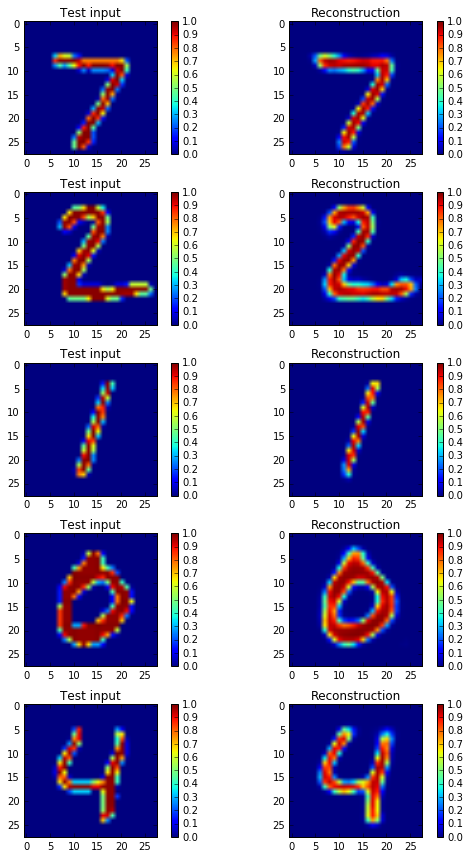

In [7]:
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = vae.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1)
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1)
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

# Check if there is representive node (like Grandmother cell)

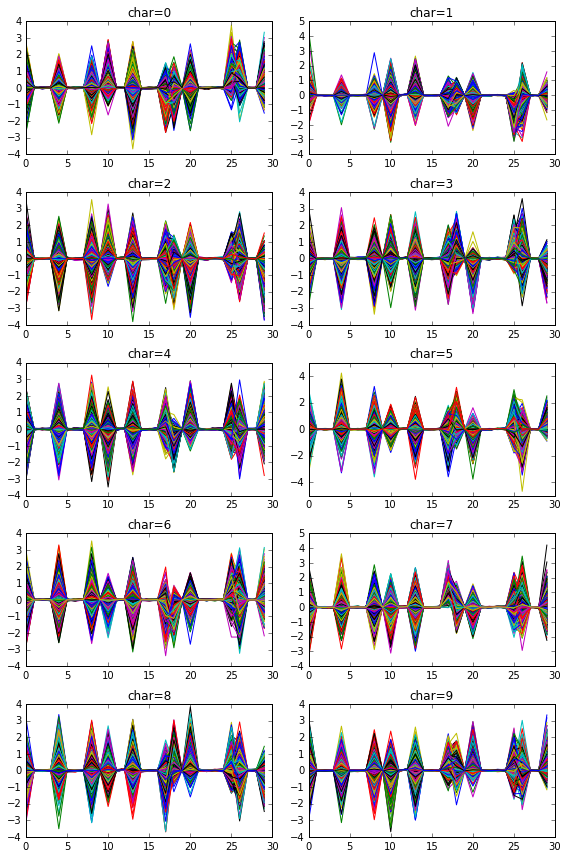

In [8]:
# Display hidden layer for each character with 2D graph
# Resut: NO "representive node (like Grandmother cell)"

num_all_sample = 10000
x_sample, y_sample = mnist.test.next_batch(num_all_sample)

plt.figure(figsize=(8, 12))
x_sample_of_chars = []
for char in range(10):
    plt.subplot(5, 2, char + 1)
    index = np.arange(num_all_sample)[y_sample[:,char] == 1]
    x_sample_of_char = x_sample[index]
    x_sample_of_chars.append(x_sample_of_char)
    z_mu = vae.transform(x_sample_of_char)
    num_sample, num_label = z_mu.shape
    for i in range(num_sample):
        plt.plot(range(num_label), z_mu[i])
    plt.title("char="+str(char))
plt.tight_layout()

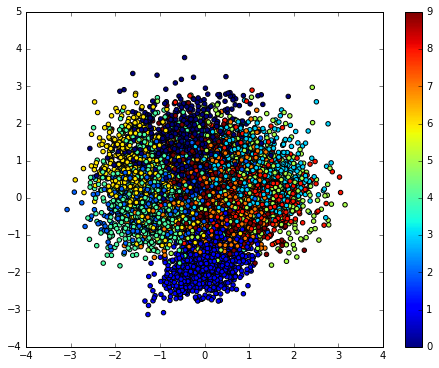

In [9]:
# Display hidden layer for each character with 2D graph

index1, index2 = 18, 25
z_mu = vae.transform(x_sample)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, index1], z_mu[:, index2], c=np.argmax(y_sample, 1))
plt.colorbar()

In [10]:
# Calculate "center of gravity" of hidden layer for each character cluster
# and distances among centers.
# Result: They are rather near!! Max distance is 11.96

# Euclidean length
def distance1(x, y):
    return np.sum((x - y)**2, axis=-1)

# Angle Distance
def distance2(x, y):
    lx = np.sqrt(np.sum(x * x, axis=-1))
    ly = np.sqrt(np.sum(y * y, axis=-1))
    return 1.0 - np.sum(x * y, axis=-1) / (lx * ly)

centers = []
z_mus = []
for char in range(10):
    z_mu = vae.transform(x_sample_of_chars[char])
    z_mus.append(z_mu)
    center = np.average(z_mu, axis=0)
    centers.append(center)

centers = np.array(centers)
centers1 = centers[np.newaxis, :, :]
centers2 = centers[:, np.newaxis, :]

print("distances1")
distances1 = (distance1(centers1, centers2)*100).astype(np.int) /100
print(distances1)

print("distances2")
distances = (distance2(centers1, centers2)*100).astype(np.int) /100
print(distances)

distances1
[[  0.    11.19   7.28   6.85   7.46   7.21   4.33   7.41   6.19   5.59]
 [ 11.19   0.     7.35   7.34   7.69   6.78   6.72   6.88   6.55   6.19]
 [  7.28   7.35   0.     4.92   7.31   8.76   6.15   7.79   5.93   8.98]
 [  6.85   7.34   4.92   0.    11.96   3.85   7.22   6.93   4.79   8.04]
 [  7.46   7.69   7.31  11.96   0.    10.49   5.16   6.36   6.18   2.93]
 [  7.21   6.78   8.76   3.85  10.49   0.     6.45   7.6    5.66   7.49]
 [  4.33   6.72   6.15   7.22   5.16   6.45   0.    10.21   7.55   6.52]
 [  7.41   6.88   7.79   6.93   6.36   7.6   10.21   0.     7.65   3.34]
 [  6.19   6.55   5.93   4.79   6.18   5.66   7.55   7.65   0.     4.54]
 [  5.59   6.19   8.98   8.04   2.93   7.49   6.52   3.34   4.54   0.  ]]
distances2
[[ 0.    1.63  1.05  1.01  1.06  1.02  0.64  1.09  1.01  0.98]
 [ 1.63  0.    1.1   1.13  1.14  1.    1.04  1.06  1.13  1.15]
 [ 1.05  1.1   0.    0.74  1.07  1.27  0.94  1.18  1.    1.66]
 [ 1.01  1.13  0.74  0.    1.8   0.57  1.13  1.08  0.83  1

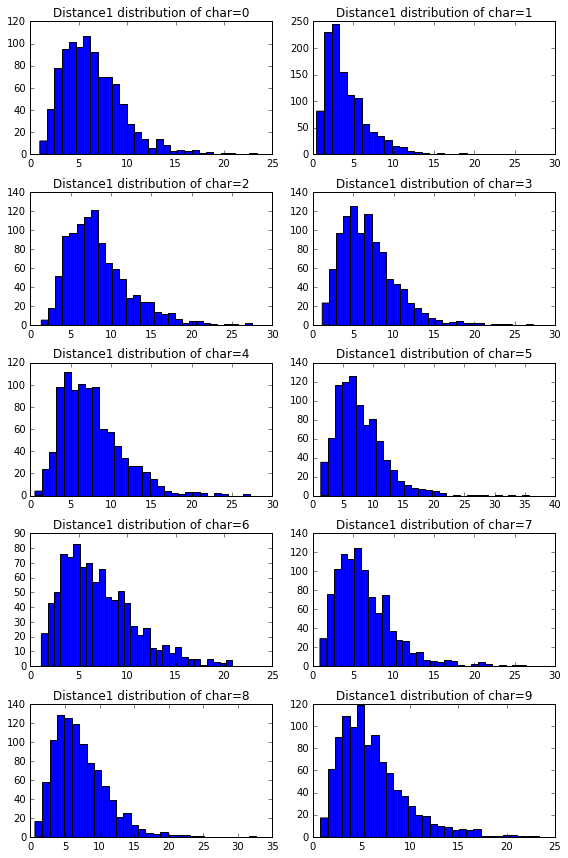

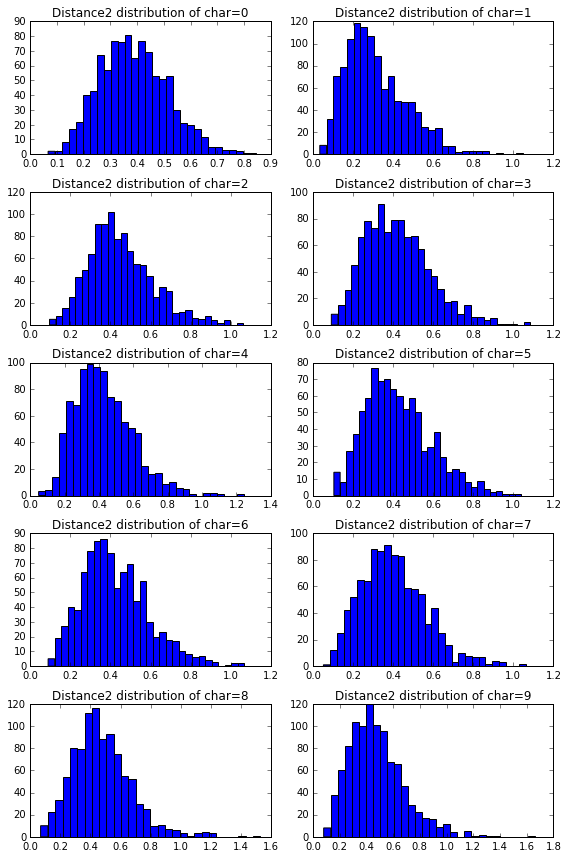

In [11]:
# Display histgrom of distance in each charcter cluster.
# Result: Some data in cluster are farther than other center!!

plt.figure(figsize=(8, 12))
z_mus = np.array(z_mus)
for char in range(10):
    plt.subplot(5, 2, char + 1)
    z_mu = z_mus[char]
    center = centers[char]
    d = distance1(z_mu, center)
    plt.hist(d, bins=30)
    plt.title("Distance1 distribution of char="+str(char))
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 12))
z_mus = np.array(z_mus)
for char in range(10):
    plt.subplot(5, 2, char + 1)
    z_mu = z_mus[char]
    center = centers[char]
    d = distance2(z_mu, center)
    plt.hist(d, bins=30)
    plt.title("Distance2 distribution of char="+str(char))
plt.tight_layout()
plt.show()

In [12]:
# Calculate ratio of data in cluster of which nearest center is its center
# Result: 89.3% (84.9% - 97.4% )of cluster member are nearest from the center

far_xs = []
nearest_centers1 = []
total_count = 0
total_ok_count = 0
for i in range(10):
  z_mu = z_mus[i]
  distance1i = distance1(z_mu, centers[i])
  distance2i = distance2(z_mu, centers[i])
  i_is_nearest1 = np.ones(z_mu.shape[0])
  i_is_nearest2 = np.ones(z_mu.shape[0])
  i_is_nearest  = np.ones(z_mu.shape[0])

  nearest_center1i  = np.ones(z_mu.shape[0], dtype=np.int) * i
  nearest_disance1i = np.copy(distance1i)

  for j in range(10):
    if i == j:
      continue
    distance1j = distance1(z_mu, centers[j])
    distance2j = distance2(z_mu, centers[j])
    i_is_near1 = (distance1i < distance1j).astype(np.int)
    i_is_near2 = (distance2i < distance2j).astype(np.int)
    i_is_near  = np.maximum(i_is_near1, i_is_near2)
    i_is_nearest1 = i_is_nearest1 * i_is_near1
    i_is_nearest2 = i_is_nearest2 * i_is_near2
    i_is_nearest  = i_is_nearest  * i_is_near

    j_is_near1 = distance1j < nearest_disance1i
    nearest_disance1i[j_is_near1] = distance1j[j_is_near1]
    nearest_center1i[j_is_near1] = j
    
  i_is_far = (np.ones_like(i_is_nearest) - i_is_nearest).astype(np.bool)
  far_x = x_sample_of_chars[i][i_is_far]
  far_xs.append(far_x)
  nearest_centers1.append(nearest_center1i[i_is_far])
    
  ok_count1 = np.sum(i_is_nearest1)
  ok_count2 = np.sum(i_is_nearest2)
  ok_count  = np.sum(i_is_nearest )
  ok_ratio1 = ok_count1/z_mu.shape[0]
  ok_ratio2 = ok_count2/z_mu.shape[0]
  ok_ratio  = ok_count/z_mu.shape[0]
  print("Ratio of neaest members from center {}: nearest1={:.0f}({:.1f}%), nearest2={:.0f}({:.1f}%), nearest={:.0f}({:.1f}%)".format(
        i, ok_count1, ok_ratio1*100, ok_count2, ok_ratio2*100, ok_count, ok_ratio*100))
  total_count += z_mu.shape[0]
  total_ok_count += ok_count

total_ok_ratio = total_ok_count / total_count
total_ng_count = total_count - total_ok_count
total_ng_ratio = total_ng_count / total_count
print("OK={:.0f}/{:.0f}({:.1f}%), NG={:.0f}/{:.0f}({:.1f}%)".format(
      total_ok_count, total_count, total_ok_ratio*100, total_ng_count, total_count, total_ng_ratio*100))

Ratio of neaest members from center 0: nearest1=949(96.8%), nearest2=952(97.1%), nearest=952(97.1%)
Ratio of neaest members from center 1: nearest1=1105(97.4%), nearest2=1106(97.4%), nearest=1106(97.4%)
Ratio of neaest members from center 2: nearest1=888(86.0%), nearest2=891(86.3%), nearest=892(86.4%)
Ratio of neaest members from center 3: nearest1=863(85.4%), nearest2=868(85.9%), nearest=870(86.1%)
Ratio of neaest members from center 4: nearest1=855(87.1%), nearest2=863(87.9%), nearest=865(88.1%)
Ratio of neaest members from center 5: nearest1=782(87.7%), nearest2=786(88.1%), nearest=786(88.1%)
Ratio of neaest members from center 6: nearest1=835(87.2%), nearest2=831(86.7%), nearest=835(87.2%)
Ratio of neaest members from center 7: nearest1=927(90.2%), nearest2=926(90.1%), nearest=927(90.2%)
Ratio of neaest members from center 8: nearest1=832(85.4%), nearest2=821(84.3%), nearest=838(86.0%)
Ratio of neaest members from center 9: nearest1=857(84.9%), nearest2=817(81.0%), nearest=857(84.9

In [13]:
# Generate images of centers
np_centers = np.zeros((100,30))
np_centers[:10] = centers
center_images = vae.generate(np_centers)

# of far data for char 0 = 28
# of far data for char 1 = 29
# of far data for char 2 = 140
# of far data for char 3 = 140
# of far data for char 4 = 117
# of far data for char 5 = 106
# of far data for char 6 = 123
# of far data for char 7 = 101
# of far data for char 8 = 136
# of far data for char 9 = 152


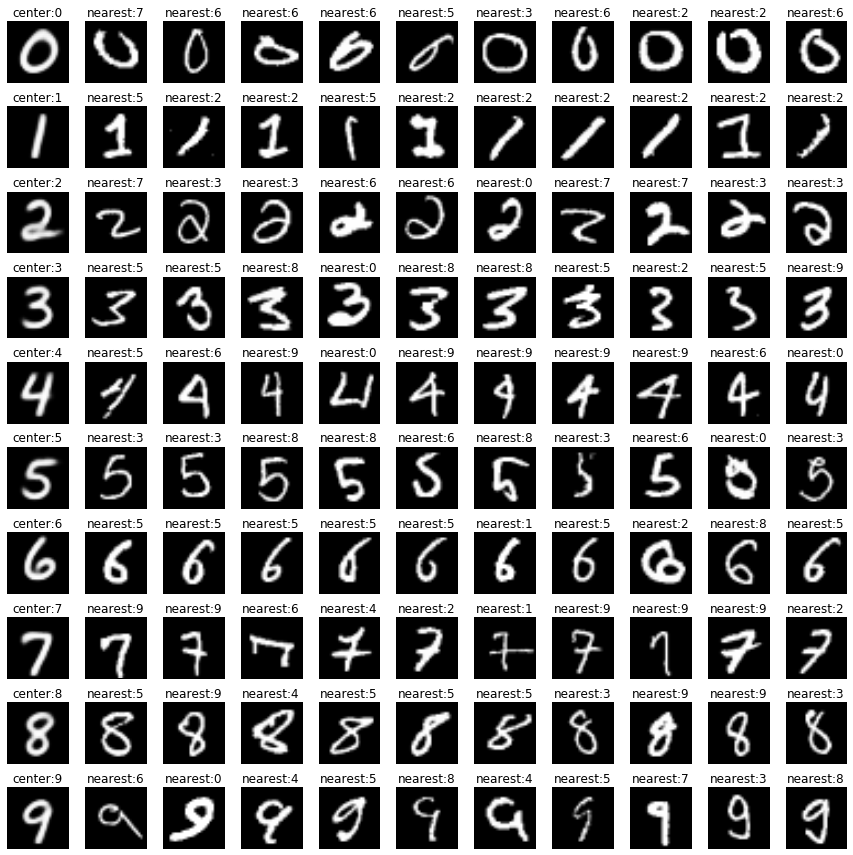

In [14]:
# Generate images far from center

cols = 10
offset = 0
plt.figure(figsize=(12, 12))
for i in range(10):
    plt.subplot(10, (cols + 1), (cols + 1)*i + 1)
    plt.imshow(center_images[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("center:"+str(i))
    plt.xticks([])
    plt.yticks([])

    len_far_i = len(far_xs[i])
    print("# of far data for char {} = {}".format(i, len_far_i))
    for j in range(offset, min(offset + cols, len_far_i)):
      plt.subplot(10, (cols + 1), (cols + 1)*i + j + 2)
      plt.imshow(far_xs[i][j].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
      plt.title("nearest:" + str(nearest_centers1[i][j]))
      plt.xticks([])
      plt.yticks([])
plt.tight_layout()

In [15]:
# Calculate Variance-covariance matrix for each char-cluster
from scipy.stats import norm

covs = []
covis = []
ps = []
for i in range(10):
    z = z_mus[i].T
    u = centers[i]
    n = len(z)

    z0 = z - u[:, None]
    cov = np.dot(z0, z0.T)/n
    covi = np.linalg.inv(cov)
    covs.append(cov)
    covis.append(covi)
    
    d = np.sum(z0 *  np.dot(covi, z0), axis=0)
    p = norm.pdf(d)
    ps.append(p)

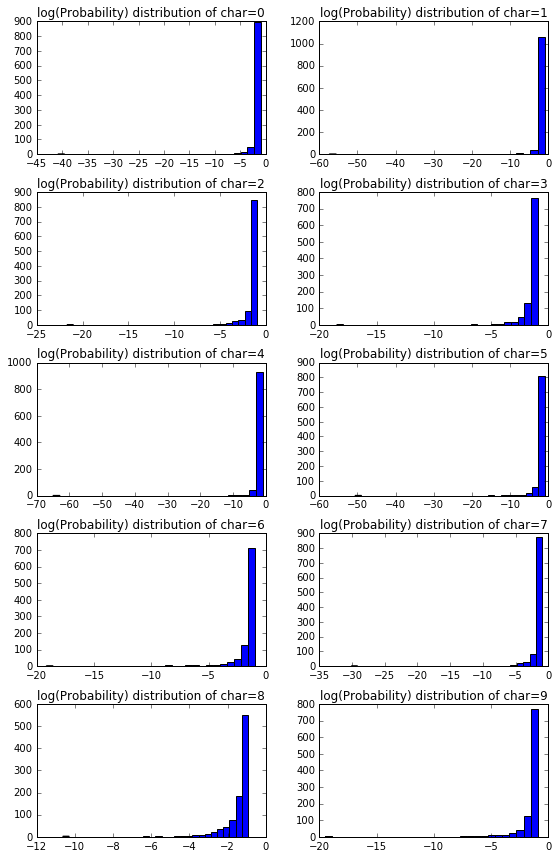

In [16]:
# Display histgrom of log(probability) in each char-cluster

plt.figure(figsize=(8, 12))
z_mus = np.array(z_mus)
for char in range(10):
    plt.subplot(5, 2, char + 1)
    p = ps[char]
    plt.hist(np.log(p), bins=30)
    plt.title("log(Probability) distribution of char="+str(char))
plt.tight_layout()
plt.show()

In [17]:
# Calculate ratio of data in cluster of which nearest center is its center
# Result: 95.2% (88.2% - 99.1%) of cluster member are nearest from the center

far_xs = []
nearest_centers = []
total_count = 0
total_ok_count = 0
for i in range(10):
  z_mu = z_mus[i]
  n = z_mu.shape[0]
  z = z_mu.T  
  pi = ps[i]
  i_is_nearest = np.ones(n)
  nearest_center  = np.ones(n, dtype=np.int) * i
  nearest_p = np.copy(pi)
  for j in range(10):
    if i == j:
      continue
    
    u = centers[j]
    z0 = z - u[:, None]
    covij = covis[j]
    d = np.sum(z0 *  np.dot(covij, z0), axis=0)
    pj = norm.pdf(d)
    
    i_is_near = (pi > pj).astype(np.int)
    i_is_nearest  = i_is_nearest  * i_is_near
    
    j_is_near = nearest_p < pj
    nearest_p[j_is_near] = pj[j_is_near]
    nearest_center[j_is_near] = j
    
  i_is_far = (np.ones_like(i_is_nearest) - i_is_nearest).astype(np.bool)
  far_x = x_sample_of_chars[i][i_is_far]
  far_xs.append(far_x)
  nearest_centers.append(nearest_center[i_is_far])
    
  ok_count  = np.sum(i_is_nearest )
  ok_ratio  = ok_count/n
  ng_count  = z_mu.shape[0] - ok_count
  ng_ratio  = ng_count/n
  print("Ratio of neaest members from center {}: ok={:.0f}({:.1f}%), ng={:.0f}({:.1f}%)".format(
        i, ok_count, ok_ratio*100, ng_count, ng_ratio*100))
  total_count += n
  total_ok_count += ok_count

total_ok_ratio = total_ok_count / total_count
total_ng_count = total_count - total_ok_count
total_ng_ratio = total_ng_count / total_count
print("OK={:.0f}/{:.0f}({:.1f}%), NG={:.0f}/{:.0f}({:.1f}%)".format(
      total_ok_count, total_count, total_ok_ratio*100, total_ng_count, total_count, total_ng_ratio*100))

Ratio of neaest members from center 0: ok=950(96.9%), ng=30(3.1%)
Ratio of neaest members from center 1: ok=1065(93.8%), ng=70(6.2%)
Ratio of neaest members from center 2: ok=1023(99.1%), ng=9(0.9%)
Ratio of neaest members from center 3: ok=948(93.9%), ng=62(6.1%)
Ratio of neaest members from center 4: ok=969(98.7%), ng=13(1.3%)
Ratio of neaest members from center 5: ok=850(95.3%), ng=42(4.7%)
Ratio of neaest members from center 6: ok=903(94.3%), ng=55(5.7%)
Ratio of neaest members from center 7: ok=975(94.8%), ng=53(5.2%)
Ratio of neaest members from center 8: ok=946(97.1%), ng=28(2.9%)
Ratio of neaest members from center 9: ok=890(88.2%), ng=119(11.8%)
OK=9519/10000(95.2%), NG=481/10000(4.8%)


# of far data for char 0 = 30
# of far data for char 1 = 70
# of far data for char 2 = 9
# of far data for char 3 = 62
# of far data for char 4 = 13
# of far data for char 5 = 42
# of far data for char 6 = 55
# of far data for char 7 = 53
# of far data for char 8 = 28
# of far data for char 9 = 119


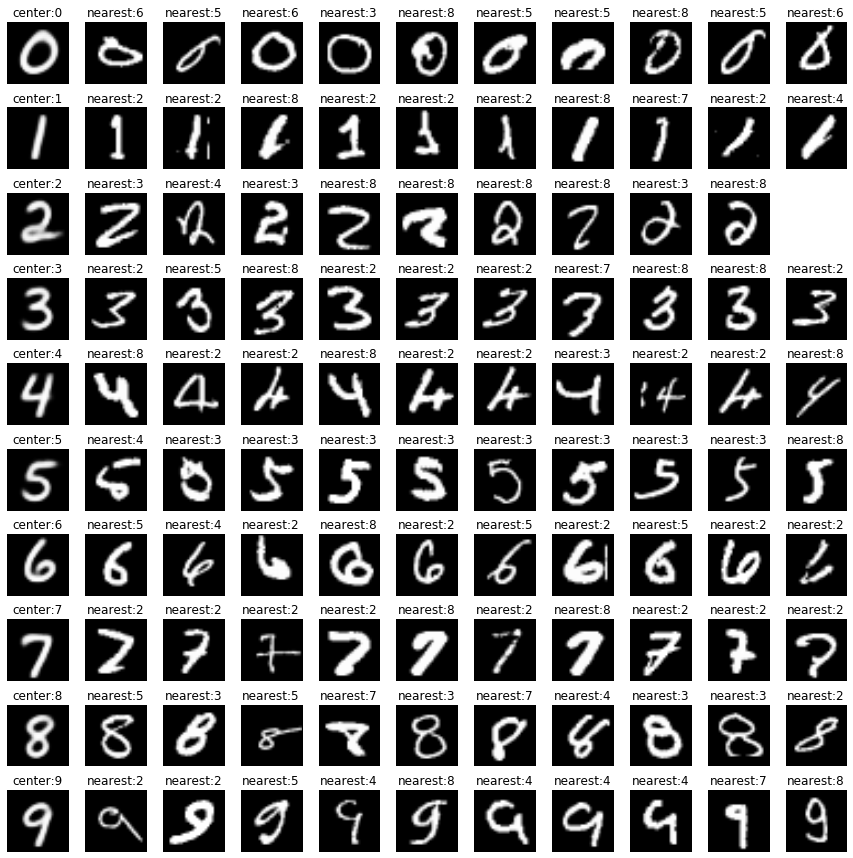

In [18]:
# Generate images far from center

cols = 10
offset = 0
plt.figure(figsize=(12, 12))
for i in range(10):
    plt.subplot(10, (cols + 1), (cols + 1)*i + 1)
    plt.imshow(center_images[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("center:"+str(i))
    plt.xticks([])
    plt.yticks([])

    len_far_i = len(far_xs[i])
    print("# of far data for char {} = {}".format(i, len_far_i))
    for j in range(offset, min(offset + cols, len_far_i)):
      plt.subplot(10, (cols + 1), (cols + 1)*i + j + 2)
      plt.imshow(far_xs[i][j].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
      plt.title("nearest:" + str(nearest_centers[i][j]))
      plt.xticks([])
      plt.yticks([])
plt.tight_layout()

In [19]:
# Calculate centers of char-images

centers = []
for i in range(10):
    x_sample = x_sample_of_chars[i]
    center = np.average(x_sample, axis=0)
    centers.append(center)
centers = np.array(centers)

In [20]:
# Try to calculate Variance-covariance matrix for each char-cluster
# Result: Fails because det(cov) = 0

covs = []
covis = []
ps = []
for i in range(10):
    z = x_sample_of_chars[i].T
    u = centers[i]
    n = len(z)

    z0 = z - u[:, None]
    cov = np.dot(z0, z0.T)/n
    det = np.linalg.det(cov)
    print("det=", det)
    rank = np.linalg.matrix_rank(cov)
    print("rank=", rank)
    covi = np.linalg.inv(cov)
    covs.append(cov)
    covis.append(covi)
    
    d = np.sum(z0 *  np.dot(covi, z0), axis=0)
    p = norm.pdf(d)
    ps.append(p)


det= 0.0
rank= 391


LinAlgError: Singular matrix

In [21]:
cov.shape

(784, 784)

## Summary
In summary, tensorflow is well suited to rapidly implement a prototype of machine learning models like VAE. The resulting code could be easily executed on GPUs as well (requiring just that tensorflow with GPU support was installed). VAE allows learning probabilistic encoders and decoders of data in an end-to-end fashion.